## Get area code for each trip

In [1]:
import osmnx as ox
import pickle
import igraph as ig
import itertools
import time
from compress_pickle import dump as cdump
from compress_pickle import load as cload
import networkx as nx
import osmnx as ox
import pickle
import osmnx as ox
import pickle
import os, sys
import pickle, csv
import numpy as np
import pandas as pd
import glob
import warnings
import geojson
import geopandas as gpd

warnings.filterwarnings("ignore")

In [5]:
df = gpd.read_file("..//..//..//Database//NYC_area//NYC Taxi Zones.geojson")
df["x"] = df["geometry"].centroid.x
df["y"] = df["geometry"].centroid.y
# see if any two locations has the same location_id
df = df.groupby("location_id").mean().reset_index()
df

,location_id,x,y
0,1,-74.174000,40.691831
1,10,-73.790986,40.678953
2,100,-73.988787,40.753513
3,101,-73.711026,40.745994
4,102,-73.875736,40.703546
...,...,...,...
255,95,-73.847669,40.721432
256,96,-73.871558,40.697001
257,97,-73.974882,40.690787
258,98,-73.777253,40.734463


In [6]:
# df = df[['location_id','x','y','geometry']]
df.columns = ["oxmid", "x", "y"]

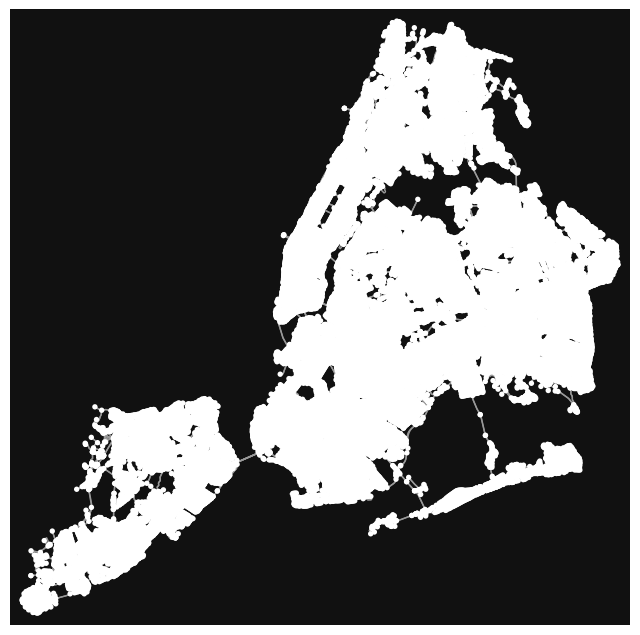

In [7]:
place = ["NYC,NY,USA"]
G = ox.graph_from_place(place, retain_all=True, simplify=True, network_type="drive")
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)
pickle.dump(G, open("..//..//..//Database//NYC_area//nyc_ox.pkl", "wb"), pickle.HIGHEST_PROTOCOL)

In [8]:
# Preprocess graph to transform into IGraph
GNSp = pickle.load(open("..//..//..//Database//NYC_area//nyc_ox.pkl", "rb"), encoding="bytes")
# impute speed on all edges missing data
GNSp = ox.add_edge_speeds(GNSp)
# calculate travel time (seconds) for all edges
GNSp = ox.add_edge_travel_times(GNSp)

# Preprocess graph to transform into IGraph
osmids = list(GNSp.nodes)
GNSp = nx.relabel.convert_node_labels_to_integers(GNSp)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(GNSp.nodes, osmids)}
osmid_values_r = {v: k for k, v in osmid_values.items()}
# nx.set_node_attributes(GNSp, osmid_values, "osmid")

# convert networkx graph to igraph
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(GNSp.nodes)
G_ig.add_edges(GNSp.edges())
G_ig.vs["osmid"] = osmids

# Get weights
for w in ["travel_time", "length"]:
    G_ig.es[w] = list(nx.get_edge_attributes(GNSp, w).values())

In [9]:
s = []
# Calculate all routes
for i in range(len(df)):
    s.append(ox.distance.nearest_nodes(GNSp, df["x"][i], df["y"][i], return_dist=False))

In [10]:
# see if any two nodes has the same nearest node
from collections import Counter

b = dict(Counter(s))
print([(key, value) for key, value in b.items() if value > 1])

[]


In [11]:
NYC_area = G_ig.shortest_paths(
    source=s, target=s, weights="travel_time", mode="out"
)
np.save("..//..//..//Database//NYC_area//NY_area.npy", NYC_area)
print("Done!")
assert np.array(NYC_area).shape[0] == df["oxmid"].nunique()
assert np.array(NYC_area).shape[1] == df["oxmid"].nunique()

Done!


In [13]:
area1 = pd.DataFrame(NYC_area)
area1.columns = df["oxmid"]
area1.index = df["oxmid"]
area1.columns = [int(float(s)) for s in area1.columns]
area1.index = [int(float(s)) for s in area1.index]
# fix some locations that has inf travel time to anywhere
area1.loc[:, 44] = area1.loc[44, :]
area1.loc[240, :] = area1.loc[:, 240]
area1.to_csv("..//..//..//Database//NYC_area//NY_area_df.csv")

In [22]:
# area = np.load("..//..//..//Database//NYC_area//NY_area.npy")
area = pd.read_csv("..//..//..//Database//NYC_area//NY_area_df.csv", index_col=0)
area.columns = [int(float(s)) for s in area.columns]
area.index = [int(float(s)) for s in area.index]

# make sure there are no inf/nan time in the table
assert sum(area[area == np.inf].count().sort_values()) == 0
assert sum(area[area == np.nan].count().sort_values()) == 0
